# Pybamm - C-Rate Experiment - Testnotebook
In diesem Notebook soll eine Simulation einer NMC811 Zelle mit Daten aus der Literatur basierend mit einem Laborzellenaufbau mit einem NMC811/Graphit PAT-Zellaufbau in 3-Elektrodenanordnung verglichen werden. Die Literaturdaten basieren auf einem Paper von Chen et al. aus dem Jahr 2020<sup>1</sup>. Für eine genaue Simulation werden charakterische Unterschiede zwischen den experimentellen und Literaturdaten bestimmt und, aufgrund der erkannten Unterschiede, die entsprechenden Parameter angepasst.

Dies sind zum geometrische, elektrische und thermodynamische Eigenschaften. Auf diese wird an entsprechender Stelle im Verlauf des Notebooks mit Hinweis auf PyBaMMs zugrundliegende Struktur hingewiesen. 

Vor Beginn der Simulation müssen alle notwendigen Pakete geladen werden. Dabei ist allen voran das Modelltoolbox "PyBaMM" zu nennen.

<sup>1</sup>: Chang-Hui Chen, Ferran Brosa Planella, Kieran O’Regan, Dominika Gastol, W. Dhammika Widanage, and Emma Kendrick. Development of Experimental Techniques for Parameterization of Multi-scale Lithium-ion Battery Models. Journal of The Electrochemical Society, 167(8):080534, 2020. doi:10.1149/1945-7111/ab9050 

In [1]:
%pip install pybamm -q    # install PyBaMM if it is not installed
import pybamm
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os


# os.chdir(pybamm.__path__[0]+'/..')
print(os.getcwd())
# print(__file__)
# print(os.path.dirname(__file__))

ERROR: Invalid requirement: '#'


Note: you may need to restart the kernel to use updated packages.
c:\Users\ahe16\Documents\GitHub\PyBaMM_Fork\scripts\testing\Laborzelle\C_rate_experiment


#### Determine your path!
Bitte hier einmal deinen lokalen Pfand zu dem Verzeichnis wo das Skript lieght hinlegen. Ich habe es bei mir bisher leider nicht geschafft den Ablageort des Skripts direkt über Python zu bestimmten

In [2]:
# pathlib.Path("")
# pathlib.Path.cwd()
print(os.path.abspath(""))

c:\Users\ahe16\Documents\GitHub\PyBaMM_Fork\scripts\testing\Laborzelle\C_rate_experiment


## 1 Modellwahl
In der Arbeitsabfolge muss nächst anhand der Anforderungen an die zu gewinnen Modelllöung ein geeigneter Lithium Ionen Modellansatz gewählt werden. Bei Beachtung der Fragestellungen im Graduiertenkolleg wird ein elektrochemisches und physikalisches Modell gewählt, was eine gute Dokumentation und Genauigkeit aufweist. Das ist das *Doyle-Fuller-Newman* Modell. Dieses wird entsprechend auch für dieses C-Raten Beispiel gewählt, um möglichst sinnvolle Erfahrungen für die spätere Anwendung zu sammeln.

Das in **PyBaMM** gewählte Modell legt fest welche Parameter für die Simulation benötigt werden. Die gesamte Liste kann über den Befehl `model.print_parameter_info` eingesehen werden. Die Parameter unterscheiden sich dabei in zwei Kategorien. Es gibt *Parameter*, die als Konstanten definiert werden, und es gibt *FunctionParameter*, die durch eine Funktion in Abhängigkeit von den gegebenen Inputgrößen berechnet werden.

Mit den Parametern werden für das gewählte Modell eine Vielzahl von Variablen örtlich und/oder zeitlich berechnet. Diese können analog zu den Parametern durch den Befehl `model.variable_names` auch in Gänze ausgegeben werden. Zur Suche nach einzelnen Variablen in der "dict" Struktur kann außerdem der Befehl `model.variables.search("*suchbegriff*")` genutzt werden.

#### to do
- Annahmen für das DFN Modell auflisten
- Erweitert sich die Liste automatisch wenn man einzelne Untermodelle austauscht oder verändert?
- Möglichkeit zur Nutzung mehrerer Modell für den direkten Vergleich mit aufnehmen

In [3]:
model = pybamm.lithium_ion.DFN()

# Auflistung aller von dem gewählten Modell benötigten Parameter
model.print_parameter_info()

# Beispiel für Auflistung aller von dem Modell berechneten Variablen bzw. Variablen mit bestimmten "Worten".
# model.variable_names
# model.variables.search("Negative electrode porosity")


Negative electrode electrons in reaction (Parameter)
Maximum concentration in positive electrode [mol.m-3] (Parameter)
Separator thickness [m] (Parameter)
Initial concentration in electrolyte [mol.m-3] (Parameter)
Typical current [A] (Parameter)
Typical electrolyte concentration [mol.m-3] (Parameter)
Negative electrode Bruggeman coefficient (electrode) (Parameter)
Negative electrode thickness [m] (Parameter)
Maximum concentration in negative electrode [mol.m-3] (Parameter)
Positive electrode Bruggeman coefficient (electrode) (Parameter)
Electrode height [m] (Parameter)
Positive electrode electrons in reaction (Parameter)
Negative electrode Bruggeman coefficient (electrolyte) (Parameter)
Initial temperature [K] (Parameter)
Positive electrode thickness [m] (Parameter)
Separator Bruggeman coefficient (electrolyte) (Parameter)
Positive electrode Bruggeman coefficient (electrolyte) (Parameter)
Number of cells connected in series to make a battery (Parameter)
Reference temperature [K] (Param

## 2 Parameterbestimmung
Die zur Beschreibung des Batteriesystems nötigen Gleichungen werden durch das Modell definiert.  Aus anfängliches Parameter Set wird, wie zuvor erwähnt, das Set von Chen et al. (2020) gewählt. Diese können für die einzelnen entweder Konstanten für *Parameter* oder Funktionen und Look Up tables (intern interpoliert) für *FunctionParameter* definiert sein. Das hier gewählte Parameter Set beschreibt ein kommerzielles NMC811/Graphite-SiO<sub>x</sub> Materialsystem in dem zyklindrischen 21700 Format (Produktname: LGM50). Das Set hier hat mehr Parameter, als das Modell benötigt. Zusätzliche Angaben werden nicht von dem gewählten Modell beachtet, außer es werden entsprechende Untermodell eingesetzt.

Analog zu der Möglichkeit der Variablen Suche für das Modell können auf eine analoge Weise über `parameter_values.search("*Suchbegriff*")` die einzelnen Parameter gesucht werden.

Dadurch ergeben sich deutliche Unterschiede in der Geometrie und bei der negativen Elektrode im Vergleich zum zu vergleichenden Laborzellensystem.

#### to do
- Mehr Parameter anpassen

In [4]:
parameter_values = pybamm.ParameterValues("Chen2020")
parameter_values.search("porosity") # Suche
# parameter_values # Vollständige Parameterliste

Negative electrode porosity	0.25
Positive electrode porosity	0.335
Separator porosity	0.47


### Anpassung geometrische Daten
Umrechnen von Durchmesser der Laborzellenelektroden von 18 mm in eine quadratische Oberfläche, da die Elektrodenfläche in PyBaMM als viereckige Fläche berechnet wird.

In [5]:
Diameter=18e-3
cell_geoquad= (Diameter**2/4*np.pi)**(1/2)
print(cell_geoquad)

0.015952084658149644


Zur Modellierung der Laborzelle müssen weitere Parameter angepasst werden.

In [6]:

### Elektrische Parameter
parameter_values["Upper voltage cut-off [V]"] = 4.2
parameter_values["Lower voltage cut-off [V]"] = 3.0
parameter_values["Nominal cell capacity [A.h]"] = 5.1e-3 # only for conversion between current and C-rate

## Geometrische Parameter der Aktivmterialien zur Berechnung der Kapazität
parameter_values["Positive electrode porosity"] = 0.39
parameter_values["Negative electrode porosity"] = 0.25
parameter_values["Positive electrode thickness [m]"] = 4.24e-5 #measured thickness - collector foil thickness of data sheet (20 µm)
parameter_values["Negative electrode thickness [m]"] = 5.0e-5  #measured thickness - collector foil thickness of data sheet (14 µm)
parameter_values["Electrode width [m]"] = cell_geoquad
parameter_values["Electrode height [m]"] = cell_geoquad
parameter_values["Positive electrode active material volume fraction"] = 1-parameter_values["Positive electrode porosity"] # fraction of filled proes to active material - not binder or composition of active material
parameter_values["Negative electrode active material volume fraction"] = 1-parameter_values["Negative electrode porosity"] # fraction of filled proes to active material - not binder or composition of active material

## Geometrische Separatorwerte
parameter_values["Separator thickness [m]"] = 2.6e-4
parameter_values["Separator porosity"] = 0.91
# parameter_values["Typical electrolyte concentration [mol.m-3]"] = 


## Experimentdefinition - C rate test
Definition von Experiment. Bringen auf richten Ausgangszustand zuvor

In [7]:
C_Rate_test = pybamm.Experiment(
    [
        ("Discharge at 1 C until 3.0 V",
        "Rest for 5 minutes",
        "Charge at 1 C until 4.2 V",
        "Hold at 4.2 V until C/10",
        "Rest for 5 minutes"),
    ] * 1
) #for 1 hours or

# "Charge at 1 C until 4.2 V",
#         "Hold at 4.2 V until C/10",
#         "Rest for 5 minutes",

In [8]:
sim = pybamm.Simulation(model, parameter_values=parameter_values, experiment=C_Rate_test)
t_eval = np.arange(0, 12001, 1)
sol = sim.solve(initial_soc=1) #[0, 7200], t_eval=t_eval, initial_soc=1
sim.plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=3.172677703606512, step=0.03172677703606512)…

In [9]:
model.variables.search("voltage")
output_variables = ["Positive electrode potential [V]", "Negative electrode potential [V]" , "Terminal voltage [V]","Positive electrode stoichiometry","Negative electrode stoichiometry","Measured open circuit voltage [V]"]
sim.plot(output_variables=output_variables)

Battery voltage [V]
Change in measured open circuit voltage
Change in measured open circuit voltage [V]
Local voltage
Local voltage [V]
Measured battery open circuit voltage [V]
Measured open circuit voltage
Measured open circuit voltage [V]
Terminal voltage
Terminal voltage [V]
X-averaged battery open circuit voltage [V]
X-averaged open circuit voltage
X-averaged open circuit voltage [V]


interactive(children=(FloatSlider(value=0.0, description='t', max=3.172677703606512, step=0.03172677703606512)…

### Suche nach Variablen in verschiedenen Sets
Anteilige Auflistung der Spannungsanteile zur Spannungskurve

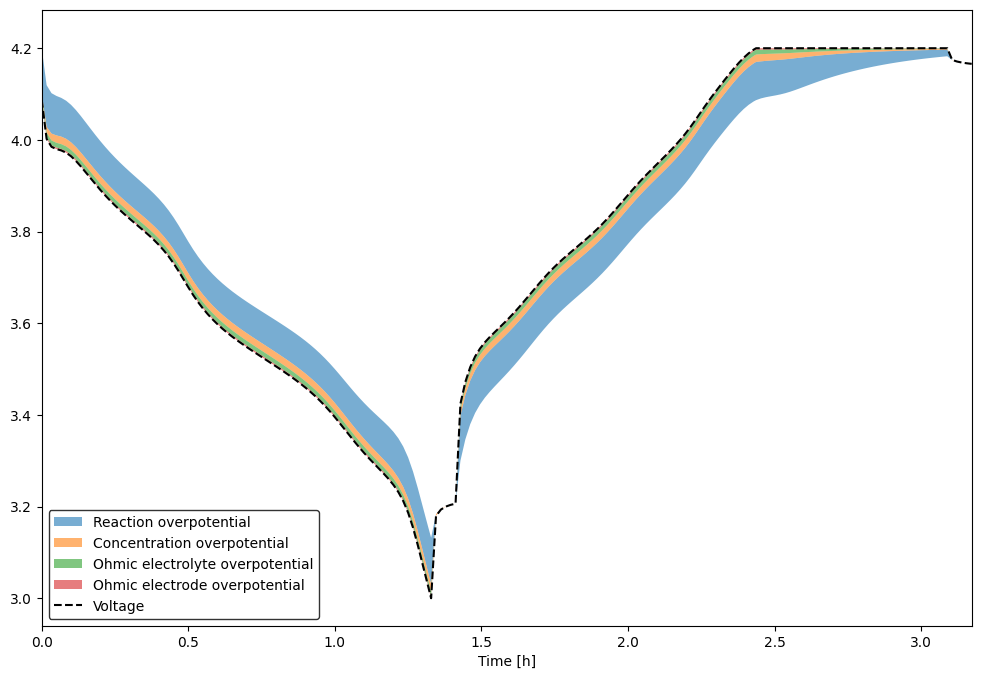

In [10]:
# f = figsize=(20,8)

# test=os.environ.get('PYTHONPATH', '').split(os.pathsep)
# print(test)

fig,ax1 = plt.subplots()
fig.set_size_inches(12,8)
pybamm.plot_voltage_components_wo_OCV(sol,ax=ax1)
# xpoints = np.array([1, 8])
# ypoints = np.array([3, 10])
# plt.plot(xpoints, ypoints)
plt.savefig(r"C:\Users\ahe16\Documents\GitHub\PyBaMM_Fork\scripts\testing\Laborzelle\C_rate_experiment\test.jpg",dpi=400,bbox_inches='tight',pad_inches=0)

### Hinzufügen/Verändern von ParametersSets
**PyBaMM** folgt einer eigenen Struktur bei der Suche und Definition von Variablen. Die Parameter Sets werden grundsätzlich durch ihre `chemistry` defininiert. Diese ist wie folgt aufgebaut (am Bespiel von Chen2020)
{'chemistry': 'lithium_ion',
 'cell': 'LGM50_Chen2020',
 'negative electrode': 'graphite_Chen2020',
 'separator': 'separator_Chen2020',
 'positive electrode': 'nmc_Chen2020',
 'electrolyte': 'lipf6_Nyman2008',
 'experiment': '1C_discharge_from_full_Chen2020',
 'sei': 'example',
 'citation': 'Chen2020'}

Die Aufteilung nach den einzelnen Batteriekomponenten lässt sich auch in der Ordnerstruktur wiederfinden, die nach den einzelnen Komponenten aufgeteilt ist. Jeder "Komponenten-Ordner" enthält dabei eine *parameters.csv* Datei, die alle aus der Literaturqulle die für diese Komponente definierten Inhalte auflistet. Anhand der struktureller Merkmale, ist **PyBaMM** fähig die Parameter aus den Parameterlisten zu bestimmen. Auf *FunctionParameter* wird in *parameters.csv* jedoch nur namentlich verwiesen. Es findet sich eine entsprechende Python Funktion oder .csv (look up table) in dem gleichen Ordner. Bei den Funktionen handelt es meist um einen kontinuierlichen Fit der diskreten experimentellen Daten. Bei .csv werden die Tabellenwerten din **PyBaMM** interpoliert.

Um eigene Parameter Sets zu definieren muss eine entsprechende  `chemistry` erstellt werden. Alternativ können die einzelnen Komponenten des gewählten Sets auch ausgetauscht werden. Um selbst Komponenten zu erstellen, sollten diese in der gleichen Struktur wie die original Komponenten von **PyBaMM** definiert sein. Die einzelnen Komponenten werden entlang bestimmter Pfade von **PyBaMM** gesucht. Diese können von **PyBaMM** über `print(pybamm.PARAMETER_PATH)` dargestellt werden. Wichtig ist, dass bei gleichnamigen Komponenten, immer die von dem zuletzt durchsuchten Pfad genommen werden.

### 

In [11]:
chemistry = pybamm.parameter_sets.Chen2020
chemistry
# Show the PyBaMM Paths where the parameter sets are looked for
print(pybamm.PARAMETER_PATH)
#print

['c:\\Users\\ahe16\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages', 'c:\\Users\\ahe16\\Documents\\GitHub\\PyBaMM_Fork\\scripts\\testing\\Laborzelle\\C_rate_experiment', 'c:\\Users\\ahe16\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\pybamm\\input\\parameters']


### Studie zu den Anfangswertbedinungen
Bei der Definition der Experimente ist es wichtig auf den gleichen Anfangszustand zu kommen. Dazu gibt es bei der Simulation ([Dokumentation-Simulation](https://pybamm.readthedocs.io/en/latest/_modules/pybamm/simulation.html#Simulation.solve)) der Lösung, die Möglichkeit die den anfänglichen Ladezustand über `initial_soc` (0 bis 1) den anfänglichen Ladezustand zu bestimmen. 

#### Wie bestimmt sich SOC im DFN Modell?
Der Ladezustand ist in P2D Modellen von Lithium-Ionen Batterien über die den Anteil der Lithiumionenkonzentration $x$ in den Partikeln des Aktivmaterials gegenüber der maximalen Konzentration von Kathode und Anode bestimmt. Dies wird in PyBaMM auch als `initial_stoichiometries` beschrieben.

$$ x = \frac{c_s}{c_s^{max}} $$
<span style="color:grey">Quelle: *Chen.2020*</span>.

Der anfängliche Ladezustand wird dann anhand von Lade- und Entladeschlussspannung, sowie den OCV Kurven zu der negativen und positiven Elektrode bestimmt. Die OCV Kurven werden wie von der Modellparameterliste getrennt für Kathode und Anode festgelegt. Wie dort auch festgelegt ist das Potential abhängig von der Stöchiometrie in dem Aktivmaterial, also wie oben das Verhältnis der Lithiumionenkonzentration gegenüber der maximalen Konzentration in dem Material. Je nach Festlegung der Ladeschlussspannungen wird nur ein Teil der theoretischen Kapazität der Materialien genutzt, was sich in der Praxis meist durch eine dadurch höhrere Lebensdauer lohnt.

##### To do 
- Tiefer einsteigen
- OCV Kurven fr Kathode und Anode tauschen
- Gibt es noch andere Abhängigkeiten bei der Begrenzung der OCV Fenster als Ladeschlussspannungen?


#### Definition des vorherigen Zellhistorie
Bei der Simulation von Vorgängen sollte auf die Historie der Zelle geachtet werden, so kann der Anfangszustand driekt vor dem Test der eigentlich simuliert werden soll, auch simuliert werden.


In [12]:
param = pybamm.LithiumIonParameters()
V_min = parameter_values.evaluate(param.voltage_low_cut_dimensional)
V_max = parameter_values.evaluate(param.voltage_high_cut_dimensional)
C_n = parameter_values.evaluate(param.n.cap_init)
C_p = parameter_values.evaluate(param.p.cap_init)
n_Li = parameter_values.evaluate(param.n_Li_particles_init)

x, y = pybamm.lithium_ion.get_initial_stoichiometries(1, parameter_values)
# pybamm.lithium_ion.ElectrodeSOHSolver
print(x,y)
# pybamm.plot(sol.t,sol.y)


0.9094754608648402 0.26384913524416187


#### Wie kann die von der Stöchiometrie abhängige OCV Kurve bestimmt werden?
Die Stöchiometrie abhängigen OCV Kurven müssen für die positive und negative Elektrode festgelegt werden, da diese im Modell zur Berechnung der Spannungs und Kinetik essenziell wichtig sind. Die positive Elektrode wird während der Entladung vollständig liithiert. Die negative Elektrode wird nicht vollständig lithiiert und nicht vollständig. Eine Lithium-Ionen Batterievollzelle ist in der Regel durch die theoretische Kapazität der der positiven Elektrode limitiert. Für eine Vollzelle können im 3-Elektrodensetup die Halbzellspannungen gegen Lithium über den Spannungsbereich der Vollzelle aufgenommen werden. Um den praktisch genutzten Ladezustand mit dem Lihtiierungsgrad der Elektroden in Zusammenhang zu bringen sind außerdem Tests an Li-Halbzellen notwenig, um über Lithiierungsbereich der Vollzelle hinaus zu testen und so den Zustand vollständige Lithiierung und Delithiierung zu erreichen.

Unter dieser Annahme können die Stöchiometriedaten mit den Ladezustandsdaten über die Zellspannungen gefittet werden. So kann jedem Ladezustand eine Stöchiometrie zugewiesen werden.

Als vergleichbares Parameterset für NMC811/Graphit wird Chen et al <sup>1</sup> herangezogen.

Die Parametersets lassen sich unter \pybamm\input\parameters\lithium_ion\data\nmc_LGM50_ocp_Chen2020.csv" bzw. "pybamm\input\parameters\lithium_ion\data\graphite_LGM50_ocp_Chen2020.csv" finden.

---
<sup>1</sup> Chen, Chang-Hui; Brosa Planella, Ferran; O’Regan, Kieran; Gastol, Dominika; Widanage, W. Dhammika; Kendrick, Emma (2020): Development of Experimental Techniques for Parameterization of Multi-scale Lithium-ion Battery Models. In: J. Electrochem. Soc. 167 (8), S. 80534. DOI: 10.1149/1945-7111/ab9050.

### Save data to csv and matlab for further analysis

In [13]:
# sol.save_data(r"C:\Users\ahe16\Documents\GitHub\PyBaMM_Fork\scripts\testing\Laborzelle\C_rate_experiment\Crate_data.csv", ["Time [s]", "Current [A]", "Terminal voltage [V]"], to_format="csv")
# sol.save_data(r"C:\Users\ahe16\Documents\GitHub\PyBaMM_Fork\scripts\testing\Laborzelle\C_rate_experiment\Crate_data.mat", ["Time [s]", "Current [A]", "Terminal voltage [V]"], to_format="matlab",
            #   short_names={"Time [s]": "t", "Current [A]": "I", "Terminal voltage [V]": "V"})


how to change the time of export?

In [14]:

#print(sol["Time [s]"])